In [1]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as transforms

In [2]:
train_image_path = Path('./TrafficSignDetection/train/images')
train_anno_path = Path('./TrafficSignDetection/train/labels')

valid_image_path = Path('./TrafficSignDetection/valid/images')
valid_anno_path = Path('./TrafficSignDetection/valid/labels')

test_image_path = Path('./TrafficSignDetection/test/images')
test_anno_path = Path('./TrafficSignDetection/test/labels')

image_path = {'train': train_image_path, 'valid': valid_image_path, 'test': test_image_path}
anno_path = {'train': train_anno_path, 'valid': valid_anno_path, 'test': test_anno_path}

In [3]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

In [4]:
def generate_annolist(anno_paths):
    annotations = filelist(anno_paths, '.txt')
    anno_list = []
    for anno_path in annotations:
        file = anno_path
        file = open(anno_path) 
        line = file.readline().split(" ")
        anno_list.append(line)
    return anno_list

In [5]:
df_train_anno = generate_annolist(anno_path['train'])

print(len(df_train_anno))   # train dataset = 3530
print(df_train_anno[36])

train_labels = []
for idx, item in enumerate(df_train_anno):
    bbox = np.array([float(element) for element in item[1:]])
    train_labels.append(torch.from_numpy(bbox))

print(len(train_labels))
print(train_labels[36])

3530
['6', '0.5072115384615384', '0.5144230769230769', '0.8353365384615384', '0.8449519230769231']
3530
tensor([0.5072, 0.5144, 0.8353, 0.8450], dtype=torch.float64)


In [6]:
train_labels = torch.stack(train_labels, dim = 0)

In [7]:
train_labels

tensor([[0.5337, 0.3173, 0.1695, 0.3173],
        [0.5769, 0.3606, 0.4159, 0.2752],
        [0.5180, 0.4856, 0.6226, 0.4507],
        ...,
        [0.6695, 0.4363, 0.2728, 0.4387],
        [0.6430, 0.4868, 0.5841, 0.8534],
        [0.5012, 0.3065, 0.6502, 0.4459]], dtype=torch.float64)

In [8]:
def generate_imagelist(image_paths):
    images = filelist(image_paths, '.jpg')
    image_list = []
    for image in images:
        image_list.append(image)
    return image_list

In [9]:
train_image_list = generate_imagelist(image_path['train'])

print(len(train_image_list)) 
train_image_list

3530


['TrafficSignDetection\\train\\images\\000000_jpg.rf.b11f308f16626f9f795a148029c46d10.jpg',
 'TrafficSignDetection\\train\\images\\000005_jpg.rf.d730849ae93a7c211a7c8f57ed851028.jpg',
 'TrafficSignDetection\\train\\images\\000007_jpg.rf.226fe0751cf8ba445b8f87970e70f606.jpg',
 'TrafficSignDetection\\train\\images\\000008_jpg.rf.bd6ae6db0f8c0eb727706bc322ce21ae.jpg',
 'TrafficSignDetection\\train\\images\\000009_jpg.rf.df4118d1d26fa7a25923521216cc2f64.jpg',
 'TrafficSignDetection\\train\\images\\00000_00000_00000_png.rf.55d47572c5980af0892b0c2ada6dae77.jpg',
 'TrafficSignDetection\\train\\images\\00000_00000_00000_png.rf.eb9b5799307ebcf07dd4c95eac0e6d13.jpg',
 'TrafficSignDetection\\train\\images\\00000_00000_00001_png.rf.56c1f101f790944f14f215c7cad2a2b8.jpg',
 'TrafficSignDetection\\train\\images\\00000_00000_00001_png.rf.8bc8cc5e727cfd7e81b5184a15dd6fc1.jpg',
 'TrafficSignDetection\\train\\images\\00000_00000_00002_png.rf.c8ad86390583e313b909403180f01ffd.jpg',
 'TrafficSignDetection\\t

(416, 416, 3)


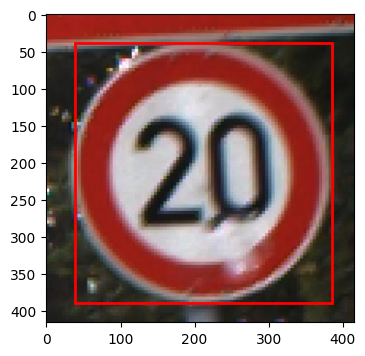

In [10]:
# Sample of train image
im = cv2.imread(str(train_image_list[36]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(4, 4))
plt.imshow(im)
print(im.shape) # (416, 416, 3)

height, width, _ = im.shape
bbox_data = train_labels[36] # bbox_data

# Calculate bounding box coordinates in absolute values
x_center = int(bbox_data[0] * width)
y_center = int(bbox_data[1] * height)
box_width = int(bbox_data[2] * width)
box_height = int(bbox_data[3] * height)

# Calculate top-left corner coordinates
xmin = x_center - (box_width // 2)
ymin = y_center - (box_height // 2)

# Add bounding box
rect = plt.Rectangle((xmin, ymin), box_width, box_height,
                     fill=False, edgecolor='red', linewidth=2)
plt.gca().add_patch(rect)
plt.show()

In [11]:
num_train_images = len(train_image_list)
width = 416
height = 416
channels = 3

train_images_dataset = np.empty((num_train_images, width, height, channels), dtype=int)

for idx, name in enumerate(train_image_list):
    img_name = name
    # Use you favourite library to load the image
    image = plt.imread(img_name)
    train_images_dataset[idx] = image

train_images = []
for idx in range(len(train_images_dataset)):
    train_images.append((torch.from_numpy(train_images_dataset[idx])))

train_images[36]

tensor([[[162,  34,  25],
         [162,  34,  25],
         [162,  34,  25],
         ...,
         [144,  29,  24],
         [144,  31,  27],
         [145,  32,  28]],

        [[162,  34,  25],
         [162,  34,  25],
         [162,  34,  25],
         ...,
         [143,  30,  24],
         [144,  31,  25],
         [143,  32,  25]],

        [[162,  34,  25],
         [162,  34,  25],
         [162,  34,  25],
         ...,
         [142,  31,  22],
         [142,  31,  22],
         [140,  32,  22]],

        ...,

        [[ 31,  31,  29],
         [ 31,  31,  29],
         [ 31,  31,  29],
         ...,
         [ 39,  37,  24],
         [ 38,  36,  23],
         [ 38,  36,  23]],

        [[ 31,  31,  29],
         [ 31,  31,  29],
         [ 31,  31,  29],
         ...,
         [ 38,  36,  23],
         [ 38,  36,  21],
         [ 38,  36,  21]],

        [[ 31,  31,  29],
         [ 31,  31,  29],
         [ 31,  31,  29],
         ...,
         [ 38,  36,  23],
        

In [12]:
train_images = torch.stack(train_images, dim = 0)

In [13]:
train_images

tensor([[[[ 67,  96, 156],
          [ 66,  95, 155],
          [ 65,  94, 154],
          ...,
          [120, 109,  87],
          [131, 117,  90],
          [ 91,  78,  46]],

         [[ 67,  96, 156],
          [ 66,  95, 155],
          [ 65,  94, 154],
          ...,
          [112, 101,  81],
          [121, 110,  82],
          [102,  91,  61]],

         [[ 67,  96, 156],
          [ 67,  96, 156],
          [ 66,  95, 155],
          ...,
          [ 85,  78,  59],
          [100,  90,  65],
          [107,  98,  69]],

         ...,

         [[ 71,  56,  33],
          [ 73,  58,  35],
          [ 83,  68,  45],
          ...,
          [ 67,  55,  31],
          [ 69,  57,  33],
          [ 75,  63,  39]],

         [[ 50,  35,  12],
          [ 66,  51,  28],
          [ 77,  62,  39],
          ...,
          [ 57,  45,  21],
          [ 57,  45,  19],
          [ 63,  51,  25]],

         [[ 65,  50,  27],
          [ 90,  75,  52],
          [ 90,  75,  52],
         

In [14]:
class MyDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        
    def __getitem__(self, index):
        x = self.images[index]
        y = self.labels[index]
        
        return {'image': x, 'label': y}
    
    def __len__(self):
        return len(self.images)

In [15]:
train_dataset = MyDataset(train_images, train_labels)

In [16]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [17]:
for batch in train_loader:
    image = batch['image']
    label = batch['label']
    print(image.shape)
    print(label.shape)

torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])


In [18]:
iterator = iter(train_loader)
batch = next(iterator)

torch.Size([416, 416, 3])
tensor([[[227, 226, 232],
         [227, 226, 232],
         [227, 226, 232],
         ...,
         [213, 212, 220],
         [213, 212, 220],
         [213, 212, 220]],

        [[227, 226, 232],
         [227, 226, 232],
         [227, 226, 232],
         ...,
         [213, 212, 220],
         [213, 212, 220],
         [213, 212, 220]],

        [[227, 226, 232],
         [227, 226, 232],
         [227, 226, 232],
         ...,
         [213, 212, 220],
         [213, 212, 220],
         [213, 212, 220]],

        ...,

        [[163, 161, 172],
         [163, 161, 172],
         [164, 162, 173],
         ...,
         [110, 104,  44],
         [115, 109,  49],
         [110, 104,  44]],

        [[159, 157, 168],
         [160, 158, 169],
         [161, 159, 170],
         ...,
         [102,  96,  36],
         [115, 109,  49],
         [112, 106,  46]],

        [[156, 154, 165],
         [157, 155, 166],
         [160, 158, 169],
         ...,
        

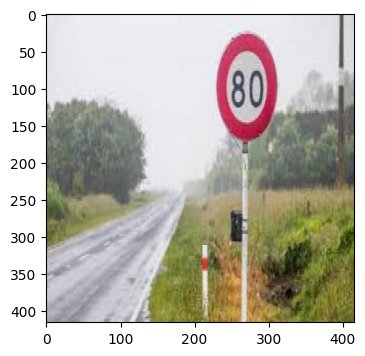

In [19]:
batch_sample_image = batch['image'][12]
print(batch_sample_image.shape)
print(batch_sample_image)
plt.figure(figsize=(4, 4))
plt.imshow(batch_sample_image)

In [20]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        # self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 15))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.bb(x)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple, dict)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
criterion = nn.CrossEntropyLoss()
model = BB_model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

c:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
train_dl = DeviceDataLoader(train_loader, device)

In [24]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [25]:
# Prepare validation dataset - labels
df_valid_anno = generate_annolist(anno_path['valid'])
valid_labels = []
for idx, item in enumerate(df_valid_anno):
    bbox = np.array([float(element) for element in item[1:]])
    valid_labels.append(torch.from_numpy(bbox))

valid_labels = torch.stack(valid_labels, dim = 0)
valid_labels

tensor([[0.2692, 0.3365, 0.4062, 0.3005],
        [0.6743, 0.5192, 0.2644, 0.6178],
        [0.5553, 0.3185, 0.3798, 0.2488],
        ...,
        [0.5288, 0.4952, 0.1743, 0.2885],
        [0.5938, 0.4279, 0.5577, 0.3413],
        [0.2163, 0.4111, 0.2007, 0.3149]], dtype=torch.float64)

In [26]:
# Prepare validation dataset - images
valid_image_list = generate_imagelist(image_path['valid'])
num_valid_images = len(valid_image_list)
width = 416
height = 416
channels = 3

valid_images_dataset = np.empty((num_valid_images, width, height, channels), dtype=int)

for idx, name in enumerate(valid_image_list):
    img_name = name
    image = plt.imread(img_name)
    valid_images_dataset[idx] = image

valid_images = []
for idx in range(len(valid_images_dataset)):
    valid_images.append((torch.from_numpy(valid_images_dataset[idx])))

valid_images = torch.stack(valid_images, dim = 0)
valid_images

tensor([[[[117, 182, 224],
          [117, 182, 224],
          [117, 182, 224],
          ...,
          [104, 169, 223],
          [104, 169, 223],
          [104, 169, 223]],

         [[117, 182, 224],
          [117, 182, 224],
          [117, 182, 224],
          ...,
          [104, 169, 223],
          [104, 169, 223],
          [104, 169, 223]],

         [[117, 182, 224],
          [117, 182, 224],
          [117, 182, 224],
          ...,
          [104, 170, 222],
          [104, 170, 222],
          [104, 170, 222]],

         ...,

         [[127, 135,  62],
          [128, 136,  61],
          [126, 137,  59],
          ...,
          [167, 155, 155],
          [167, 155, 155],
          [166, 154, 154]],

         [[129, 137,  62],
          [126, 134,  57],
          [124, 135,  56],
          ...,
          [166, 154, 154],
          [166, 154, 154],
          [165, 153, 153]],

         [[118, 126,  49],
          [114, 123,  44],
          [115, 126,  47],
         

In [27]:
valid_dataset = MyDataset(valid_images, valid_labels)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

for batch in valid_loader:
    image = batch['image']
    label = batch['label']
    print(image.shape)
    print(label.shape)

torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([33, 416, 416, 3])
torch.Size([33, 4])


In [28]:
def val_metrics(model, valid_loader):
    model.eval()
    total = 0
    sum_loss = 0
    
    for batch in valid_loader:
        """
            image -> torch.Size([64, 416, 416, 3])
            label -> torch.Size([64, 4])
        """
        batch_size = image.shape[0]
        
        x = batch['image'].float().permute(0,3,1,2)
        y = batch['label']
        predicted_label = model(x)

        loss = F.cross_entropy(predicted_label, y)

        sum_loss += loss.item()
        total += batch
        
    return sum_loss/total

In [29]:
def train_epochs(model, optimizer, train_loader, valid_loader, epochs=10):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0

        for batch in train_loader: 
            """
                image -> torch.Size([64, 416, 416, 3])
                label -> torch.Size([64, 4])
            """
            batch_size = image.shape[0]
            
            x = batch['image'].float().permute(0,3,1,2)
            y = batch['label']

            predicted_label = model(x)

            loss = F.cross_entropy(predicted_label, y)
 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total += batch_size
            sum_loss += loss.item()

        train_loss = sum_loss/total
        val_loss = val_metrics(model, valid_loader)

        print("train_loss %.3f val_loss %.3f" % (train_loss, val_loss))
        
    return sum_loss/total

In [30]:
# train_epochs(model, optimizer, train_loader, valid_loader, epochs=20)

In [31]:
# save the model
# model.save('model.h5')

# load the model
# model.load_weights(os.path.join('model.h5'))

In [32]:
# Prepare test images
test_image_list = generate_imagelist(image_path['test'])
num_test_images = len(test_image_list)
width = 416
height = 416
channels = 3

test_images_dataset = np.empty((num_test_images, width, height, channels), dtype=int)

for idx, name in enumerate(test_image_list):
    img_name = name
    image = plt.imread(img_name)
    test_images_dataset[idx] = image

test_images = []
for idx in range(len(test_images_dataset)):
    test_images.append((torch.from_numpy(test_images_dataset[idx])))

test_images

[tensor([[[188, 245, 255],
          [188, 245, 255],
          [188, 245, 255],
          ...,
          [188, 245, 255],
          [188, 245, 255],
          [188, 245, 255]],
 
         [[136, 194, 218],
          [134, 194, 218],
          [136, 194, 218],
          ...,
          [134, 194, 218],
          [136, 194, 218],
          [134, 194, 218]],
 
         [[130, 194, 222],
          [129, 194, 222],
          [130, 194, 222],
          ...,
          [129, 194, 222],
          [130, 194, 222],
          [129, 194, 222]],
 
         ...,
 
         [[197, 230, 249],
          [197, 230, 249],
          [197, 230, 249],
          ...,
          [198, 229, 250],
          [198, 229, 250],
          [198, 229, 250]],
 
         [[195, 230, 250],
          [195, 230, 250],
          [195, 230, 250],
          ...,
          [198, 229, 250],
          [198, 229, 250],
          [198, 229, 250]],
 
         [[196, 231, 251],
          [196, 231, 251],
          [196, 231, 251],
   

In [33]:
# Prepare test labels
df_test_anno = generate_annolist(anno_path['test'])
test_labels = []
for idx, item in enumerate(df_test_anno):
    bbox = np.array([float(element) for element in item[1:]])
    test_labels.append(torch.from_numpy(bbox))

test_labels = torch.stack(test_labels, dim = 0)
test_labels

tensor([[0.5000, 0.4796, 0.4675, 0.6346],
        [0.3750, 0.1671, 0.2812, 0.3305],
        [0.5276, 0.5060, 0.5709, 0.5577],
        ...,
        [0.3341, 0.5505, 0.1070, 0.0829],
        [0.2993, 0.7632, 0.0433, 0.0421],
        [0.5144, 0.5144, 0.5216, 0.5757]], dtype=torch.float64)

In [34]:
test_dataset = MyDataset(test_images, test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

for batch in test_loader:
    image = batch['image']
    label = batch['label']
    print(image.shape)
    print(label.shape)

torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([64, 416, 416, 3])
torch.Size([64, 4])
torch.Size([62, 416, 416, 3])
torch.Size([62, 4])


In [ ]:
# Evaluate the model performance using test data
total = 0
sum_loss = 0

for batch in test_loader: 
    """
        image -> torch.Size([64, 416, 416, 3])
        label -> torch.Size([64, 4])
    """
    batch_size = image.shape[0]
    
    x = batch['image'].float().permute(0,3,1,2)
    y = batch['label']

    predicted_label = model(x)

    loss = F.cross_entropy(predicted_label, y)

    total += batch_size
    sum_loss += loss.item()

test_loss = sum_loss/total

print("test_loss %.3f" % (test_loss))

(416, 416, 3)


"\nheight, width, _ = im.shape\nbbox_data = train_labels[36] # bbox_data\n\n# Calculate bounding box coordinates in absolute values\nx_center = int(bbox_data[0] * width)\ny_center = int(bbox_data[1] * height)\nbox_width = int(bbox_data[2] * width)\nbox_height = int(bbox_data[3] * height)\n\n# Calculate top-left corner coordinates\nxmin = x_center - (box_width // 2)\nymin = y_center - (box_height // 2)\n\n# Add bounding box\nrect = plt.Rectangle((xmin, ymin), box_width, box_height,\n                     fill=False, edgecolor='red', linewidth=2)\nplt.gca().add_patch(rect)\nplt.show()\n"

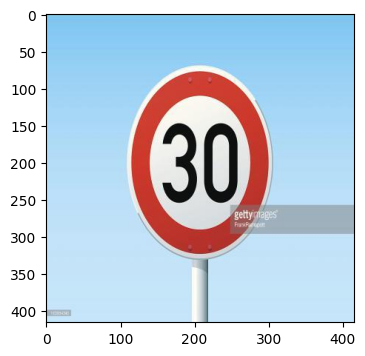

In [132]:
# Plot test image sample and bounding box
output = model(test_images[0])

im = cv2.imread(str(test_image_list[0]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(4, 4))
plt.imshow(im)
# print(im.shape) # (416, 416, 3)

height, width, _ = im.shape
bbox_data = output # the output of the model is the predicted bbox_data

# Calculate bounding box coordinates in absolute values
x_center = int(bbox_data[0] * width)
y_center = int(bbox_data[1] * height)
box_width = int(bbox_data[2] * width)
box_height = int(bbox_data[3] * height)

# Calculate top-left corner coordinates
xmin = x_center - (box_width // 2)
ymin = y_center - (box_height // 2)

# Add bounding box
rect = plt.Rectangle((xmin, ymin), box_width, box_height,
                     fill=False, edgecolor='red', linewidth=2)
plt.gca().add_patch(rect)
plt.show()